# DeepLOB: Deep Convolutional Neural Networks for Limit Order Books

### Authors: Zihao Zhang, Stefan Zohren and Stephen Roberts
Oxford-Man Institute of Quantitative Finance, Department of Engineering Science, University of Oxford

This jupyter notebook is used to demonstrate our recent paper [2] published in IEEE Transactions on Singal Processing. We use FI-2010 [1] dataset and present how model architecture is constructed here.

### Data:
The FI-2010 is publicly avilable and interested readers can check out their paper [1]. The dataset can be downloaded from: https://etsin.fairdata.fi/dataset/73eb48d7-4dbc-4a10-a52a-da745b47a649

Otherwise, the notebook will download the data automatically or it can be obtained from:

https://drive.google.com/drive/folders/1Xen3aRid9ZZhFqJRgEMyETNazk02cNmv?usp=sharing

### References:
[1] Ntakaris A, Magris M, Kanniainen J, Gabbouj M, Iosifidis A. Benchmark dataset for mid‐price forecasting of limit order book data with machine learning methods. Journal of Forecasting. 2018 Dec;37(8):852-66. https://arxiv.org/abs/1705.03233

[2] Zhang Z, Zohren S, Roberts S. DeepLOB: Deep convolutional neural networks for limit order books. IEEE Transactions on Signal Processing. 2019 Mar 25;67(11):3001-12. https://arxiv.org/abs/1808.03668

### This notebook runs on Pytorch 1.9.0.

In [ ]:
"""
import os
if not os.path.isfile('data.zip'):
    !wget https://raw.githubusercontent.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books/master/data/data.zip
    !unzip -n data.zip
    print('data downloaded.')
else:
    print('data already existed.')
"""

--2021-07-14 21:34:50--  https://raw.githubusercontent.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books/master/data/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56278154 (54M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  53.67M  67.1MB/s    in 0.8s    

2021-07-14 21:34:52 (67.1 MB/s) - ‘data.zip’ saved [56278154/56278154]

Archive:  data.zip
  inflating: Test_Dst_NoAuction_DecPre_CF_7.txt  
  inflating: Test_Dst_NoAuction_DecPre_CF_9.txt  
  inflating: Test_Dst_NoAuction_DecPre_CF_8.txt  
  inflating: Train_Dst_NoAuction_DecPre_CF_7.txt  
data downloaded.


In [2]:
!pip install torchinfo

In [3]:
# load packages
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.33)
# N, D = X_train.shape

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
"""
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)

    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY

def torch_data(x, y):
    x = torch.from_numpy(x)
    x = torch.unsqueeze(x, 1)
    y = torch.from_numpy(y)
    y = F.one_hot(y, num_classes=3)
    return x, y
"""

In [ ]:
###################### 수정
import numpy as np

### Feature와 레이블 분리
def prepare_x_from_df(df):
    features = [col for col in df.columns if ('bid_' in col or 'ask_' in col)]
    return df[features].values.astype(np.float32)


def get_label_from_df(df):
    return df['label'].astype(int).values

def data_classification(X, Y, T):
    N, D = X.shape
    dataX = np.zeros((N - T + 1, T, D), dtype=np.float32)
    dataY = Y[T - 1:N]

    for i in range(T, N + 1):
        dataX[i - T] = X[i - T:i, :]

    return dataX, dataY

def torch_data(x, y):
    x = torch.from_numpy(x).float()
    x = torch.unsqueeze(x, 1)  # (N, 1, T, D)
    y = torch.from_numpy(y).long()  # 정수 레이블
    return x, y


In [ ]:
"""
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, data, k, num_classes, T):
        """Initialization"""
        self.k = k
        self.num_classes = num_classes
        self.T = T

        x = prepare_x(data)
        y = get_label(data)
        x, y = data_classification(x, y, self.T)
        y = y[:,self.k] - 1
        self.length = len(x)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]
"""

In [6]:
######### 수정
class LOBDataset(data.Dataset):
    def __init__(self, df, T):
        self.T = T

        # 전처리
        x_all = prepare_x_from_df(df)     # shape: (N, D)
        y_all = get_label_from_df(df)     # shape: (N,)
        x_seq, y_seq = data_classification(x_all, y_all, self.T)  # (N-T+1, T, D), (N-T+1,)

        # Tensor로 변환
        self.x = torch.from_numpy(x_seq).unsqueeze(1).float()     # shape: (N, 1, T, D)
        self.y = torch.from_numpy(y_seq).long()                   # shape: (N,)

        self.length = len(self.x)

        self.num_classes = len(np.unique(y_seq))

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        return self.x[index], self.y[index]


# Data preparation

We used no auction dataset that is normalised by decimal precision approach in their work. The first seven days are training data and the last three days are testing data. A validation set (20%) from the training set is used to monitor the overfitting behaviours.  

The first 40 columns of the FI-2010 dataset are 10 levels ask and bid information for a limit order book and we only use these 40 features in our network. The last 5 columns of the FI-2010 dataset are the labels with different prediction horizons.

In [ ]:
"""
# please change the data_path to your local path
# data_path = '/nfs/home/zihaoz/limit_order_book/data'

dec_data = np.loadtxt('Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_train.shape, dec_val.shape, dec_test.shape)
"""

(149, 203800) (149, 50950) (149, 139587)


In [ ]:
"""
batch_size = 64

dataset_train = Dataset(data=dec_train, k=4, num_classes=3, T=100)
dataset_val = Dataset(data=dec_val, k=4, num_classes=3, T=100)
dataset_test = Dataset(data=dec_test, k=4, num_classes=3, T=100)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape)
"""

torch.Size([203701, 1, 100, 40]) torch.Size([203701])


In [7]:
from google.colab import files
uploaded = files.upload()  # 사용자에게 파일 업로드 받기

import pandas as pd
df = pd.read_csv("AAPL_minute_orderbook_2019_01-07_combined.csv")

Saving AAPL_minute_orderbook_2019_01-07_combined.csv to AAPL_minute_orderbook_2019_01-07_combined.csv


In [8]:
########## 수정: NaN 관련 + Z-score 정규화
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# CSV 파일 불러오기
df = pd.read_csv("AAPL_minute_orderbook_2019_01-07_combined.csv")

# 사용할 feature: 논문 기준 40개
features = []
for lvl in range(10):
    lvl_str = f"{lvl:02d}"
    features += [
        f"bid_px_{lvl_str}", f"bid_sz_{lvl_str}",
        f"ask_px_{lvl_str}", f"ask_sz_{lvl_str}"
    ]

# 중간 NaN값 선형 보간 (앞뒤 모두 활용)
df[features] = df[features].interpolate(method='linear', limit_direction='both')

# 정규화
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])  # 또는 MinMaxScaler()


# feature 추출
df_features = df[features].copy()

# mid-price 및 label 생성
df_mid = pd.DataFrame()
df_mid['mid_price'] = (df['bid_px_00'] + df['ask_px_00']) / 2
df_mid['mid_price_future'] = df_mid['mid_price'].shift(-1)
df_mid['label'] = (df_mid['mid_price_future'] > df_mid['mid_price']).astype(int) * 2 + \
                  (df_mid['mid_price_future'] == df_mid['mid_price']).astype(int) * 1

# feature + label 결합
df_all = pd.concat([df_features, df_mid['label']], axis=1)

# label이 NaN인 마지막 행만 제거
df_all = df_all.dropna(subset=['label'])
df_all['label'] = df_all['label'].astype(int)

# 학습/검증/테스트 split (시간 순서 유지)
train_df, test_df = train_test_split(df_all, test_size=0.2, shuffle=False)
train_df, val_df  = train_test_split(train_df, test_size=0.2, shuffle=False)

# Dataset 구성
T = 100
batch_size = 64

dataset_train = LOBDataset(train_df, T)
dataset_val   = LOBDataset(val_df, T)
dataset_test  = LOBDataset(test_df, T)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# shape 확인
print(dataset_train.x.shape, dataset_train.y.shape)


torch.Size([36342, 1, 100, 40]) torch.Size([36342])


In [9]:
tmp_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=1, shuffle=True)

for x, y in tmp_loader:
    print(x)
    print(y)
    print(x.shape, y.shape)
    break

tensor([[[[-0.7759, -0.4790, -0.7181,  ..., -0.4519, -0.3761, -0.1921],
          [-0.7759, -0.4790, -0.7181,  ..., -0.4519, -0.3761, -0.1921],
          [-0.7759, -0.4790, -0.7181,  ..., -0.4152, -0.3761, -0.1921],
          ...,
          [-0.7424,  0.3493, -0.7265,  ...,  1.6910, -0.6075, -0.1502],
          [-0.7329, -0.1411, -0.7265,  ..., -0.3640, -0.6075, -0.1502],
          [-0.7469, -0.4061, -0.7382,  ..., -0.4958, -0.6344, -0.1963]]]])
tensor([0])
torch.Size([1, 1, 100, 40]) torch.Size([1])


In [10]:
tmp_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=1, shuffle=True)

for x, y in tmp_loader:
    print("x:", x.dtype, x.shape)  # torch.float32, torch.Size([1, 1, 100, 40])
    print("y:", y.dtype, y.shape)  # torch.int64,    torch.Size([1])
    print("y value:", y)           # tensor([0]) 또는 tensor([2]) 등
    break

x: torch.float32 torch.Size([1, 1, 100, 40])
y: torch.int64 torch.Size([1])
y value: tensor([2])


# Model Architecture

Please find the detailed discussion of our model architecture in our paper.

In [ ]:
"""
class deeplob(nn.Module):
    def __init__(self, y_len):
        super().__init__()
        self.y_len = y_len

        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )

        # inception moduels
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )

        # lstm layers
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, self.y_len)

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(device)
        c0 = torch.zeros(1, x.size(0), 64).to(device)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)

        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)

#         x = torch.transpose(x, 1, 2)
        x = x.permute(0, 2, 1, 3)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))

        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)
        forecast_y = torch.softmax(x, dim=1)

        return forecast_y
"""

In [11]:
############## 수정3: lstm hidden unit 줄이기 + dropout
import torch
import torch.nn as nn

class deeplob(nn.Module):
    def __init__(self, y_len):
        super().__init__()
        self.y_len = y_len

        # Convolution Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(1, 2), stride=(1, 2)),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=(4, 1)),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=(4, 1)),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(32)
        )

        # Convolution Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=(4, 1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=(4, 1)),
            nn.Tanh(),
            nn.BatchNorm2d(32)
        )

        # Convolution Block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1, 10)),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=(4, 1)),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=(4, 1)),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(32)
        )

        # Inception Modules
        self.inp1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=(3, 1), padding='same'),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(64)
        )

        self.inp2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=(5, 1), padding='same'),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(64)
        )

        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(32, 64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(64)
        )

        # LSTM: 192 features from concatenated inception outputs
        self.lstm = nn.LSTM(input_size=192, hidden_size=32, num_layers=1, batch_first=True)

        self.dropout = nn.Dropout(0.3)

        # Fully connected output layer
        self.fc1 = nn.Linear(32, self.y_len)

    def forward(self, x):  # x: (B, 1, 100, 60)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)

        # Concatenate inception outputs along channel axis → (B, 192, T, 1)
        x = torch.cat([x_inp1, x_inp2, x_inp3], dim=1)

        # Reshape for LSTM input → (B, T, 192)
        x = x.squeeze(-1).permute(0, 2, 1)

        # LSTM
        x, _ = self.lstm(x)         # (B, T, 64)
        x = x[:, -1, :]             # 마지막 timestep만 사용 → (B, 64)
        x = self.dropout(x)         # Dropout 적용!
        x = self.fc1(x)             # (B, y_len)
        return x                    # softmax는 CrossEntropyLoss에서 처리됨

In [12]:
model = deeplob(y_len = dataset_train.num_classes)
model.to(device)

deeplob(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): Tanh()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): Tanh()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride

In [13]:
summary(model, (1, 1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
deeplob                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 94, 20]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 20]          96
│    └─LeakyReLU: 2-2                    [1, 32, 100, 20]          --
│    └─BatchNorm2d: 2-3                  [1, 32, 100, 20]          64
│    └─Conv2d: 2-4                       [1, 32, 97, 20]           4,128
│    └─LeakyReLU: 2-5                    [1, 32, 97, 20]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 97, 20]           64
│    └─Conv2d: 2-7                       [1, 32, 94, 20]           4,128
│    └─LeakyReLU: 2-8                    [1, 32, 94, 20]           --
│    └─BatchNorm2d: 2-9                  [1, 32, 94, 20]           64
├─Sequential: 1-2                        [1, 32, 88, 10]           --
│    └─Conv2d: 2-10                      [1, 32, 94, 10]           2,080
│    └

In [ ]:
"""
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
"""

In [14]:
##########3 수정2: lr 줄여봄
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

# Model Training


In [ ]:
"""
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):

        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            # print("inputs.shape:", inputs.shape)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss = criterion(outputs, targets)
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading

        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        if test_loss < best_test_loss:
            torch.save(model, './best_val_model_pytorch')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')

    return train_losses, test_losses
"""

In [15]:
############# 수정
from datetime import datetime
from tqdm import tqdm
import numpy as np
import torch

def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):
        model.train()
        t0 = datetime.now()
        train_loss = []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        train_loss = np.mean(train_loss)

        model.eval()
        test_loss = []
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        train_losses[it] = train_loss
        test_losses[it] = test_loss

        if test_loss < best_test_loss:
            torch.save(model, './best_val_model_pytorch')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, '
              f'Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')

    return train_losses, test_losses


In [16]:
######### 3rd trial-2: earlystopping X
train_losses, val_losses = batch_gd(model, criterion, optimizer,
                                    train_loader, val_loader,
                                    epochs=50)

  2%|▏         | 1/50 [00:19<15:55, 19.50s/it]

model saved
Epoch 1/50, Train Loss: 1.0497, Validation Loss: 1.0342, Duration: 0:00:19.497886, Best Val Epoch: 0


  4%|▍         | 2/50 [00:37<14:56, 18.68s/it]

model saved
Epoch 2/50, Train Loss: 0.9981, Validation Loss: 1.0181, Duration: 0:00:18.097308, Best Val Epoch: 1


  6%|▌         | 3/50 [00:55<14:26, 18.43s/it]

Epoch 3/50, Train Loss: 0.9733, Validation Loss: 1.0194, Duration: 0:00:18.144467, Best Val Epoch: 1


  8%|▊         | 4/50 [01:14<14:14, 18.58s/it]

model saved
Epoch 4/50, Train Loss: 0.9591, Validation Loss: 1.0112, Duration: 0:00:18.809332, Best Val Epoch: 3


 10%|█         | 5/50 [01:33<13:58, 18.64s/it]

model saved
Epoch 5/50, Train Loss: 0.9484, Validation Loss: 1.0037, Duration: 0:00:18.731530, Best Val Epoch: 4


 12%|█▏        | 6/50 [01:52<13:43, 18.71s/it]

Epoch 6/50, Train Loss: 0.9372, Validation Loss: 1.0086, Duration: 0:00:18.843009, Best Val Epoch: 4


 14%|█▍        | 7/50 [02:10<13:20, 18.62s/it]

Epoch 7/50, Train Loss: 0.9314, Validation Loss: 1.0079, Duration: 0:00:18.438646, Best Val Epoch: 4


 16%|█▌        | 8/50 [02:29<12:59, 18.57s/it]

Epoch 8/50, Train Loss: 0.9243, Validation Loss: 1.0153, Duration: 0:00:18.452940, Best Val Epoch: 4


 18%|█▊        | 9/50 [02:47<12:40, 18.54s/it]

Epoch 9/50, Train Loss: 0.9178, Validation Loss: 1.0094, Duration: 0:00:18.491269, Best Val Epoch: 4


 20%|██        | 10/50 [03:06<12:30, 18.76s/it]

Epoch 10/50, Train Loss: 0.9117, Validation Loss: 1.0172, Duration: 0:00:19.228545, Best Val Epoch: 4


 22%|██▏       | 11/50 [03:25<12:08, 18.69s/it]

Epoch 11/50, Train Loss: 0.9061, Validation Loss: 1.0167, Duration: 0:00:18.542406, Best Val Epoch: 4


 24%|██▍       | 12/50 [03:43<11:48, 18.65s/it]

Epoch 12/50, Train Loss: 0.9019, Validation Loss: 1.0220, Duration: 0:00:18.567100, Best Val Epoch: 4


 26%|██▌       | 13/50 [04:02<11:28, 18.61s/it]

Epoch 13/50, Train Loss: 0.8970, Validation Loss: 1.0325, Duration: 0:00:18.523697, Best Val Epoch: 4


 28%|██▊       | 14/50 [04:20<11:09, 18.59s/it]

Epoch 14/50, Train Loss: 0.8913, Validation Loss: 1.0369, Duration: 0:00:18.538865, Best Val Epoch: 4


 30%|███       | 15/50 [04:39<10:51, 18.60s/it]

Epoch 15/50, Train Loss: 0.8880, Validation Loss: 1.0401, Duration: 0:00:18.620130, Best Val Epoch: 4


 32%|███▏      | 16/50 [04:58<10:31, 18.58s/it]

Epoch 16/50, Train Loss: 0.8834, Validation Loss: 1.0353, Duration: 0:00:18.517339, Best Val Epoch: 4


 34%|███▍      | 17/50 [05:16<10:13, 18.58s/it]

Epoch 17/50, Train Loss: 0.8797, Validation Loss: 1.0419, Duration: 0:00:18.588152, Best Val Epoch: 4


 36%|███▌      | 18/50 [05:35<09:54, 18.57s/it]

Epoch 18/50, Train Loss: 0.8758, Validation Loss: 1.0391, Duration: 0:00:18.553253, Best Val Epoch: 4


 38%|███▊      | 19/50 [05:53<09:35, 18.57s/it]

Epoch 19/50, Train Loss: 0.8700, Validation Loss: 1.0417, Duration: 0:00:18.571881, Best Val Epoch: 4


 40%|████      | 20/50 [06:12<09:16, 18.55s/it]

Epoch 20/50, Train Loss: 0.8665, Validation Loss: 1.0475, Duration: 0:00:18.509297, Best Val Epoch: 4


 42%|████▏     | 21/50 [06:30<08:58, 18.56s/it]

Epoch 21/50, Train Loss: 0.8617, Validation Loss: 1.0537, Duration: 0:00:18.579144, Best Val Epoch: 4


 44%|████▍     | 22/50 [06:49<08:39, 18.55s/it]

Epoch 22/50, Train Loss: 0.8567, Validation Loss: 1.0619, Duration: 0:00:18.507790, Best Val Epoch: 4


 46%|████▌     | 23/50 [07:07<08:20, 18.54s/it]

Epoch 23/50, Train Loss: 0.8534, Validation Loss: 1.0602, Duration: 0:00:18.539433, Best Val Epoch: 4


 48%|████▊     | 24/50 [07:26<08:02, 18.55s/it]

Epoch 24/50, Train Loss: 0.8485, Validation Loss: 1.0611, Duration: 0:00:18.551662, Best Val Epoch: 4


 50%|█████     | 25/50 [07:45<07:43, 18.56s/it]

Epoch 25/50, Train Loss: 0.8449, Validation Loss: 1.0664, Duration: 0:00:18.583649, Best Val Epoch: 4


 52%|█████▏    | 26/50 [08:03<07:25, 18.57s/it]

Epoch 26/50, Train Loss: 0.8400, Validation Loss: 1.0705, Duration: 0:00:18.584530, Best Val Epoch: 4


 54%|█████▍    | 27/50 [08:22<07:07, 18.58s/it]

Epoch 27/50, Train Loss: 0.8366, Validation Loss: 1.0672, Duration: 0:00:18.604582, Best Val Epoch: 4


 56%|█████▌    | 28/50 [08:40<06:49, 18.62s/it]

Epoch 28/50, Train Loss: 0.8313, Validation Loss: 1.0882, Duration: 0:00:18.699013, Best Val Epoch: 4


 58%|█████▊    | 29/50 [08:59<06:31, 18.62s/it]

Epoch 29/50, Train Loss: 0.8267, Validation Loss: 1.0782, Duration: 0:00:18.642255, Best Val Epoch: 4


 60%|██████    | 30/50 [09:18<06:13, 18.68s/it]

Epoch 30/50, Train Loss: 0.8241, Validation Loss: 1.0819, Duration: 0:00:18.815108, Best Val Epoch: 4


 62%|██████▏   | 31/50 [09:37<05:54, 18.65s/it]

Epoch 31/50, Train Loss: 0.8171, Validation Loss: 1.0935, Duration: 0:00:18.581498, Best Val Epoch: 4


 64%|██████▍   | 32/50 [09:55<05:36, 18.69s/it]

Epoch 32/50, Train Loss: 0.8161, Validation Loss: 1.0978, Duration: 0:00:18.789525, Best Val Epoch: 4


 66%|██████▌   | 33/50 [10:14<05:17, 18.66s/it]

Epoch 33/50, Train Loss: 0.8094, Validation Loss: 1.1098, Duration: 0:00:18.567615, Best Val Epoch: 4


 68%|██████▊   | 34/50 [10:33<04:58, 18.66s/it]

Epoch 34/50, Train Loss: 0.8064, Validation Loss: 1.1005, Duration: 0:00:18.651840, Best Val Epoch: 4


 70%|███████   | 35/50 [10:51<04:39, 18.62s/it]

Epoch 35/50, Train Loss: 0.8010, Validation Loss: 1.1113, Duration: 0:00:18.549306, Best Val Epoch: 4


 72%|███████▏  | 36/50 [11:10<04:20, 18.62s/it]

Epoch 36/50, Train Loss: 0.7976, Validation Loss: 1.1206, Duration: 0:00:18.611232, Best Val Epoch: 4


 74%|███████▍  | 37/50 [11:28<04:01, 18.60s/it]

Epoch 37/50, Train Loss: 0.7928, Validation Loss: 1.1167, Duration: 0:00:18.562325, Best Val Epoch: 4


 76%|███████▌  | 38/50 [11:47<03:43, 18.61s/it]

Epoch 38/50, Train Loss: 0.7870, Validation Loss: 1.1299, Duration: 0:00:18.612197, Best Val Epoch: 4


 78%|███████▊  | 39/50 [12:06<03:25, 18.64s/it]

Epoch 39/50, Train Loss: 0.7851, Validation Loss: 1.1331, Duration: 0:00:18.707442, Best Val Epoch: 4


 80%|████████  | 40/50 [12:24<03:06, 18.67s/it]

Epoch 40/50, Train Loss: 0.7809, Validation Loss: 1.1427, Duration: 0:00:18.733107, Best Val Epoch: 4


 82%|████████▏ | 41/50 [12:43<02:48, 18.69s/it]

Epoch 41/50, Train Loss: 0.7755, Validation Loss: 1.1397, Duration: 0:00:18.744365, Best Val Epoch: 4


 84%|████████▍ | 42/50 [13:02<02:29, 18.67s/it]

Epoch 42/50, Train Loss: 0.7709, Validation Loss: 1.1448, Duration: 0:00:18.634994, Best Val Epoch: 4


 86%|████████▌ | 43/50 [13:20<02:10, 18.68s/it]

Epoch 43/50, Train Loss: 0.7653, Validation Loss: 1.1452, Duration: 0:00:18.698506, Best Val Epoch: 4


 88%|████████▊ | 44/50 [13:39<01:51, 18.64s/it]

Epoch 44/50, Train Loss: 0.7620, Validation Loss: 1.1616, Duration: 0:00:18.533114, Best Val Epoch: 4


 90%|█████████ | 45/50 [13:58<01:33, 18.64s/it]

Epoch 45/50, Train Loss: 0.7545, Validation Loss: 1.1618, Duration: 0:00:18.652810, Best Val Epoch: 4


 92%|█████████▏| 46/50 [14:16<01:14, 18.60s/it]

Epoch 46/50, Train Loss: 0.7523, Validation Loss: 1.1579, Duration: 0:00:18.503343, Best Val Epoch: 4


 94%|█████████▍| 47/50 [14:35<00:55, 18.61s/it]

Epoch 47/50, Train Loss: 0.7485, Validation Loss: 1.1747, Duration: 0:00:18.621271, Best Val Epoch: 4


 96%|█████████▌| 48/50 [14:53<00:37, 18.59s/it]

Epoch 48/50, Train Loss: 0.7439, Validation Loss: 1.1770, Duration: 0:00:18.552636, Best Val Epoch: 4


 98%|█████████▊| 49/50 [15:12<00:18, 18.60s/it]

Epoch 49/50, Train Loss: 0.7398, Validation Loss: 1.1885, Duration: 0:00:18.599581, Best Val Epoch: 4


100%|██████████| 50/50 [15:31<00:00, 18.62s/it]

Epoch 50/50, Train Loss: 0.7350, Validation Loss: 1.1980, Duration: 0:00:18.655155, Best Val Epoch: 4


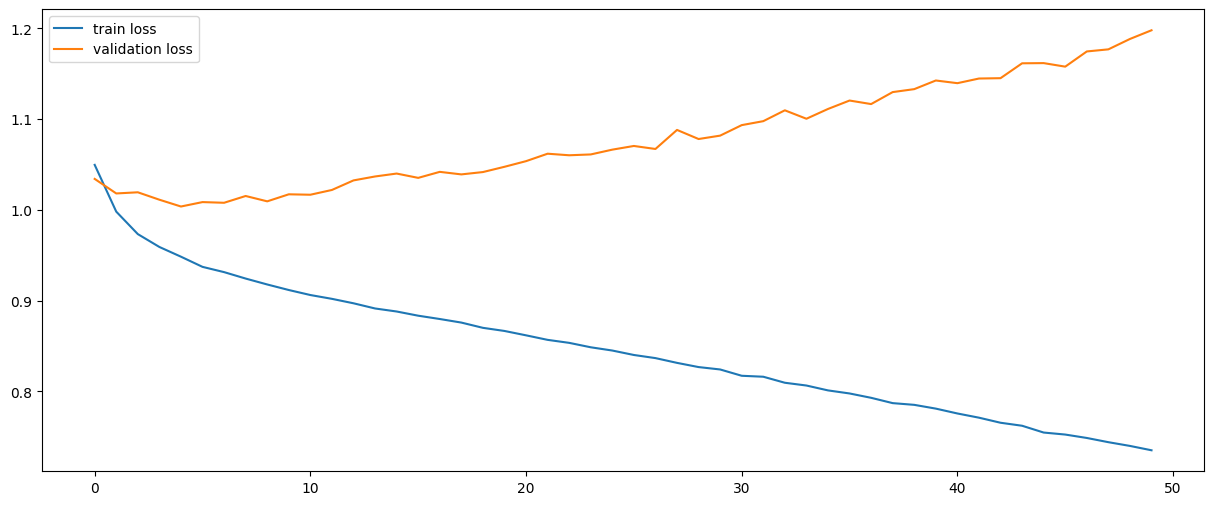

In [17]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

# Model Testing

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()
n_correct = 0
n_total = 0
all_targets = []
all_predictions = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        n_correct += (preds == targets).sum().item()
        n_total += targets.size(0)

        all_targets.append(targets.cpu().numpy())
        all_predictions.append(preds.cpu().numpy())

# 정확도 출력
test_acc = n_correct / n_total
print(f"Test Accuracy: {test_acc:.4f}")

# 정밀 분석
all_targets = np.concatenate(all_targets)
all_predictions = np.concatenate(all_predictions)

print(classification_report(all_targets, all_predictions, target_names=["Down", "Same", "Up"]))




Test Accuracy: 0.4106
              precision    recall  f1-score   support

        Down       0.39      0.36      0.37      4034
        Same       0.45      0.43      0.44      2969
          Up       0.41      0.44      0.42      4286

    accuracy                           0.41     11289
   macro avg       0.41      0.41      0.41     11289
weighted avg       0.41      0.41      0.41     11289

